In [117]:
import pandas as pd
from pathlib import Path

pq_path = Path("../data_processed/movies_clean.parquet")
df = pd.read_parquet(pq_path)

df.shape, df.head()

((4919, 29),
    color           director  num_critic_for_reviews  runtime_min  \
 0  Color      James Cameron                   723.0        178.0   
 1  Color     Gore Verbinski                   302.0        169.0   
 2  Color         Sam Mendes                   602.0        148.0   
 3  Color  Christopher Nolan                   813.0        164.0   
 4    nan        Doug Walker                     NaN          NaN   
 
    director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
 0                      0.0                   855.0  Joel David Moore   
 1                    563.0                  1000.0     Orlando Bloom   
 2                      0.0                   161.0      Rory Kinnear   
 3                  22000.0                 23000.0    Christian Bale   
 4                    131.0                     NaN        Rob Walker   
 
    actor_1_facebook_likes    gross_usd                           genres  ...  \
 0                  1000.0  760505847.0  Action|Ad

## Column Discovery
To handle column name variations, I started scanning for keywords like year, release, and rating. This quick diagnostic shows which columns are potential matches. From there, I used more robust logic to finalize which column(s) to use. 

In [138]:
[c for c in df.columns if any(k in c.lower() for k in ["year", "date", "release", "score", "rating"])]

['content_rating', 'year', 'rating']

## Column Detection
The step below ensures the correct year and ratings columns are selected, even if the dataset uses slightly different names. Using a helper function tests candidate names, confirming the ones available in the dataset. This adds flexibility to the pipeline. 

In [139]:
def pick_year_col(df):
    candidates = ["title_year","year","release_year","movie_year","year_released"]
    for c in candidates:
        if c in df.columns:
            return c
 
    for c in df.columns:
        if "year" in c.lower():
            return c
    return None

def pick_rating_col(df):
    preferred = ["imdb_rating","rating","imdb_score","score"]
    bad_tokens = {"content", "advisory", "mpaa", "certificate"}
    def is_numeric_0_10(s):
        x = pd.to_numeric(s, errors = "coerce")
        x = x[( x >= 0) & (x <= 10)]
        return x.notna().mean() > 0.6  

    for c in preferred:
        if c in df.columns and is_numeric_0_10(df[c]):
            return c

    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in ["rating","score"]) and not any(t in cl for t in bad_tokens):
            if is_numeric_0_10(df[c]):
                return c
    return None

year_col   = pick_year_col(df)
rating_col = pick_rating_col(df)

print("Using columns → year:", year_col, "| rating:", rating_col)
assert year_col is not None and rating_col is not None, "Could not find suitable year/rating columns."

Using columns → year: year | rating: rating


## Column Detection for Inconsistent Naming - Shown Below 
The dataset contains variations in column names (e.g., gross, gross_usd, and revenue). To make the notebook more robust and reusable, I added logic to automatically detect column names using pattern matching shown in the 3 following cells. 

I perfomed this by scanning all columns for applicable keywords, refining detection with regrex-based matching, and built a helper function to generalize the approcach. 

This ensures the pipeline still works even if column names differ slightly across datasets. 

In [ ]:
[c for c in df.columns if any(k in c.lower() for k in
    ["budget","gross","revenue","income","box","world","domestic","usa","rating","score","imdb"])]


import re
[c for c in df.columns if re.search(r"(gross|revenue|box[_ ]?office|world)", c, re.I)]


def pick_by_regex(patterns):
    for col in df.columns:
        for pat in patterns:
            if re.search(pat, col, re.I):
                return col
    return None

revenue_col = pick_by_regex([r"gross", r"revenue", r"box[_ ]?office", r"world"])
print("Detected revenue column:", revenue_col)
assert revenue_col, "Couldn't detect a revenue/gross column—print df.columns to inspect."



Detected revenue column: gross_usd


## Cleaning Shown Below: Budget, Revenue & Ratings
Before analysis, I ensured numeric columns were properly converted, handled missing values, and capped extreme outliers at the 95th percentile. This step makes later visualizations such as budget vs. revenue trends more interpretable. 

In [153]:
cols = [year_col, budget_col, revenue_col, rating_col]
base = df[cols].copy()

for c in cols:
    base[c] = pd.to_numeric(base[c], errors="coerce")

base = base.dropna(subset=[year_col, budget_col, revenue_col])

cap_b = base[budget_col].quantile(0.95)
cap_r = base[revenue_col].quantile(0.95)
base_clip = base[(base[budget_col] <= cap_b) & (base[revenue_col] <= cap_r)].copy()

In [152]:
missing_tokens = {"", "nan", "NaN", "NONE", "None", "N/A", "NA", "null", "Null"}
obj_cols = df.select_dtypes(include = "object").columns
for c in obj_cols:
    df[c] = (
        df[c].astype(str).str.strip()
             .replace({tok: np.nan for tok in missing_tokens})
    )

df[year_col]   = pd.to_numeric(df[year_col], errors = "coerce")
df[rating_col] = pd.to_numeric(df[rating_col], errors = "coerce")

df = df.dropna(subset = [year_col])
df = df[df[year_col].between(1970, 2020)]
df.loc[(df[rating_col] < 0) | (df[rating_col] > 10), rating_col] = np.nan

maybe_numeric = ["runtime_min", "gross_usd", "budget", "revenue"]
for c in [c for c in maybe_numeric if c in df.columns]:
    df[c] = pd.to_numeric(df[c], errors = "coerce")

df.isna().mean().sort_values(ascending=False).head(15)


gross_usd                 0.142429
budget_usd                0.080317
aspect_ratio              0.064896
content_rating            0.054187
plot_keywords             0.029771
num_critic_for_reviews    0.008567
actor_3_name              0.003641
actor_3_facebook_likes    0.003641
num_user_for_reviews      0.003213
color                     0.003213
facenumber_in_poster      0.002784
runtime_min               0.002570
actor_2_facebook_likes    0.002142
actor_2_name              0.002142
language                  0.001713
dtype: float64

In [56]:
na_summary = (
    df.isna().sum()
        .to_frame("missing_count")
        .assign(missing_pct = lambda t: (t["missing_count"] / len(df)).round(3))
        .sort_values("missing_count", ascending = False)
)
na_summary

,missing_count,missing_pct
gross_usd,863,0.175
budget_usd,485,0.099
aspect_ratio,326,0.066
year,106,0.022
decade,106,0.022
director_facebook_likes,102,0.021
num_critic_for_reviews,49,0.010
actor_3_facebook_likes,23,0.005
num_user_for_reviews,21,0.004
runtime_min,15,0.003


In [119]:
desc = df.describe(include='number').T
display(
    desc.style.format({
        'mean': '{:,.2f}', 'std': '{:,.2f}',
        'min': '{:,.0f}',  '25%': '{:,.0f}', '50%': '{:,.0f}',
        '75%': '{:,.0f}',  'max': '{:,.0f}',
    })
)


,count,mean,std,min,25%,50%,75%,max
num_critic_for_reviews,4629.000000,142.13,121.18,1,53,112,196,813
runtime_min,4657.000000,107.65,21.98,7,94,103,118,330
director_facebook_likes,4669.000000,690.09,"2,840.77",0,7,47,190,"23,000"
actor_3_facebook_likes,4652.000000,651.06,"1,664.36",0,137,382,641,"23,000"
actor_1_facebook_likes,4662.000000,"6,767.38","15,435.38",0,629,"1,000","11,000","640,000"
gross_usd,4004.000000,"47,759,091.88","67,570,027.68",162,"5,100,703","25,086,272","61,299,581","760,505,847"
num_voted_users,4669.000000,"84,457.97","140,461.97",5,"8,924","34,592","96,233","1,689,764"
cast_total_facebook_likes,4669.000000,"9,956.01","18,543.01",0,"1,442","3,185","14,168","656,730"
facenumber_in_poster,4656.000000,1.37,2.03,0,0,1,2,43
num_user_for_reviews,4654.000000,273.22,378.72,1,66,157,326,"5,060"


In [120]:
data_dict = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "pct_missing": [df[c].isna().mean() 
    for c in df.columns]
})
data_dict

,column,dtype,pct_missing
0,color,object,0.003213
1,director,object,0.000000
2,num_critic_for_reviews,float64,0.008567
3,runtime_min,float64,0.002570
4,director_facebook_likes,float64,0.000000
5,actor_3_facebook_likes,float64,0.003641
6,actor_2_name,object,0.002142
7,actor_1_facebook_likes,float64,0.001499
8,gross_usd,float64,0.142429
9,genres,object,0.000000


## Query 1: Movies per Decade 

In [93]:
sql = """

SELECT (year / 10) * 10 AS decade_start,
printf('%d0s', (year / 10)) AS decade_label,
COUNT(*) AS movie_count
FROM titles
WHERE year BETWEEN 1970 and 2020
GROUP BY decade_start
ORDER BY decade_start;
"""

In [ ]:
s = df['decade'].value_counts().sort_index().rename('movie_count')
s.index = s.index.astype(int).map(lambda d: f"{d}s")  


## Chart 1: Movies per Decade (Without Labels)
The bar chart below shows the distribution of movies across decades. By plotting counts without value labels, the focus stays on the overall trend - a sharp increase in movie producion starting in the 1980's, peaking in the 2000's. This version is cleaner for scanning the big picture quickly.

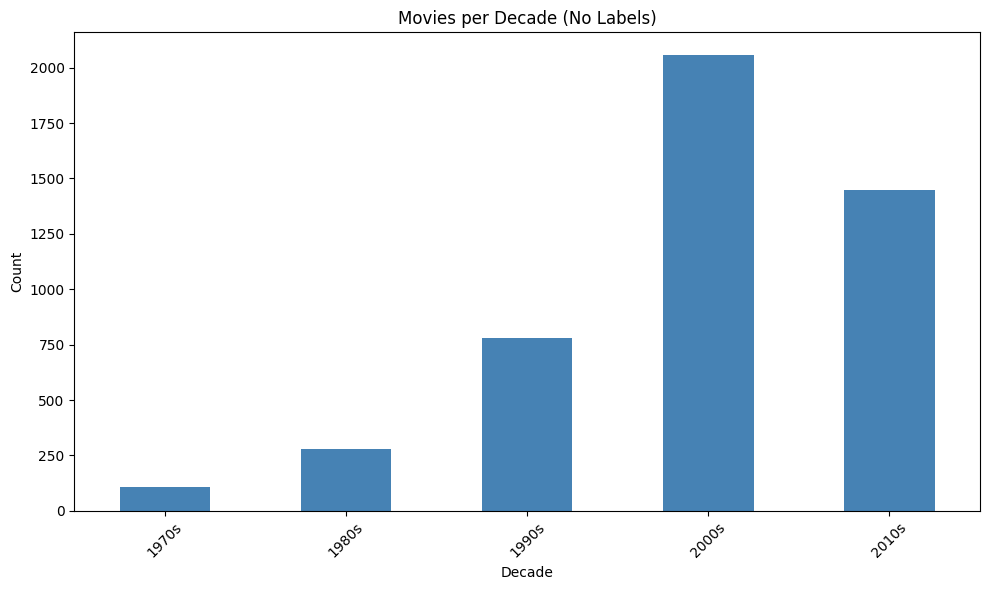

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
ax = s.plot(kind = 'bar', color = 'steelblue')
ax.set_title("Movies per Decade (No Labels)")
ax.set_xlabel("Decade")
ax.set_ylabel("Count")
plt.xticks(rotation =45)
plt.tight_layout()
plt.savefig("../visuals/movies_per_decade_nolabels.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Chart 1.1 : Movies per Decade (With Labels)
The chart version below includes value labels above each bar, making the exact counts visible. While slightly busier visually, it helps stakeholders quickly reference numbers without estimating from the y-axis. Using both versions demonstrates flexibiity in tailoring visuals for exploratory analysis vs. presentation needs. 

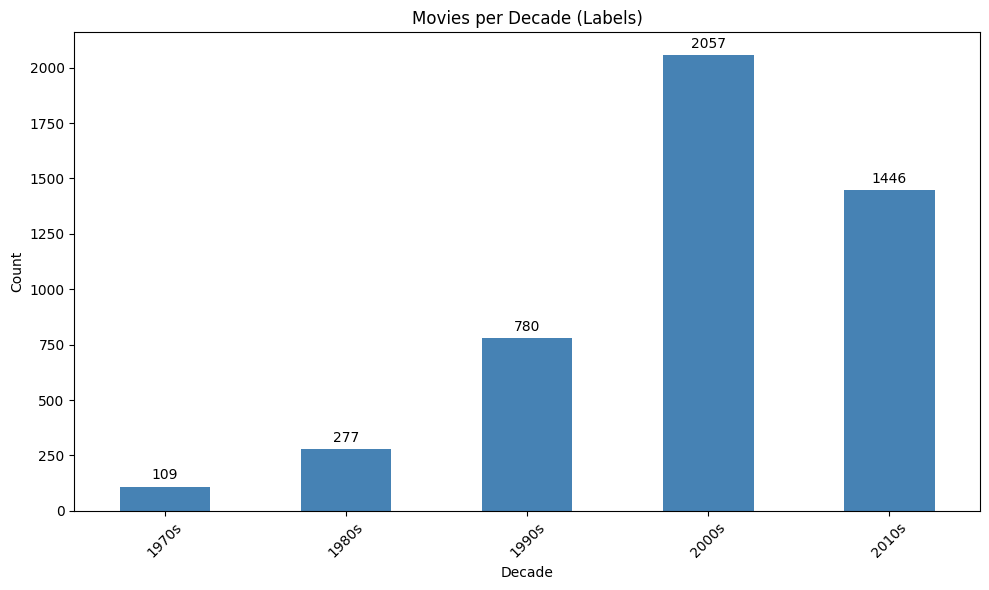

In [131]:
plt.figure(figsize=(10,6))
ax = s.plot(kind='bar', color='steelblue')
ax.set_title("Movies per Decade (Labels)")
ax.set_xlabel("Decade")
ax.set_ylabel("Count")
plt.xticks(rotation=45)

# value labels
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

plt.tight_layout()
plt.savefig("../visuals/movies_per_decade_labels.png", dpi=300, bbox_inches="tight")
plt.show()


## Query 2: Top 10 Movie Genres

In [97]:
sql = """

SELECT
    genre,
    COUNT(*) AS movie_count
FROM title_genres
GROUP BY genre
ORDER BY movie_count DESC
LIMIT 10;
"""

In [94]:
normalize_map = {
    'sci fi': 'Sci-Fi',
    'sci-fi': 'Sci-Fi',
    'science fiction': 'Sci-Fi',
    'romcom': 'Romance',
    'rom-com': 'Romance',
    'crime drama': 'Crime',
    'action/adventure': 'Action',
}

g = (
    df['genres'].astype(str).str.strip()
      .str.lower()
      .replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
)

delim = '|' if g.str.contains(r'\|', na=False).any() else ','

genre_long = (
    g.dropna()
     .str.split(delim)
     .explode()
     .str.strip()
     .replace(normalize_map)
     .str.title()
)

genre_long = genre_long[genre_long.notna() & (genre_long != '')]

counts = genre_long.value_counts()
top_n = 10
top_genres = counts.head(top_n).rename_axis('genre').rename('count').reset_index()
top_genres['share_pct'] = (top_genres['count'] / counts.sum() * 100).round(1)

top_genres.to_csv("../visuals/top_genres_top10.csv", index=False)

top_genres

,genre,count,share_pct
0,Drama,2535,17.9
1,Comedy,1848,13.1
2,Thriller,1364,9.7
3,Action,1113,7.9
4,Romance,1084,7.7
5,Adventure,888,6.3
6,Crime,869,6.1
7,Sci-Fi,595,4.2
8,Fantasy,583,4.1
9,Horror,540,3.8


## Chart 2: Top 10 Most Common Genres
The chart below shows the distribution of the top 10 most common movie genres in the dataset. *Drama* dominates by a wide margin, followed by *Comedy*, *Thriller*, and *Action*. Genres like *Sci-Fi*, *Fantasy*, and *Horror* appear less frequently. This breakdown higlights the strong industry emphasis on story-driven genres (Drama/Comedy), while niche categories remain under-represented. 

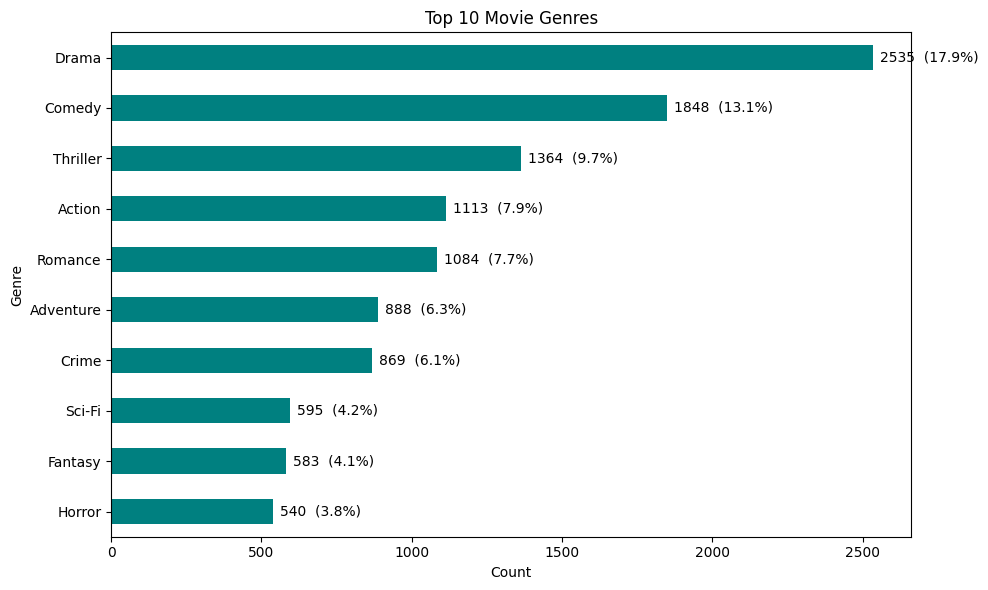

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
ax = top_genres.set_index('genre')['count'].sort_values(ascending = True).plot(
    kind = 'barh', color = 'teal'
)
ax.set_title("Top 10 Movie Genres")
ax.set_xlabel("Count")
ax.set_ylabel("Genre")

for p, pct in zip(ax.patches, top_genres.sort_values('count')['share_pct'].tolist()):
    ax.annotate(f"{int(p.get_width())}  ({pct}%)",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                va = 'center', ha = 'left', xytext = (5, 0), textcoords = 'offset points')

plt.tight_layout()
plt.savefig("../visuals/top_genres.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Query 3: IMDb Ratings Distribution

In [98]:
sql = ''' 

SELECT CAST(rating AS REAL) AS rating
FROM titles_with_ratings
WHERE rating IS NOT NULL
    AND rating BETWEEN 0 AND 10;
'''


## Chart 3: Ratings Distribution (bell curve)
The bell-shaped curve below shows how IMDb ratings roughly follow a normal distribution. About 68% of movies fall within one standard versin of the mean rating (~6-7), 95% within two standard deviations (~5-8), and 99.7% within three (~4-9). This illustrates the 68-95-99.7 rule, confirming that most ratings cluster near the average, with fewer movies receiving very low or very high ratings. 

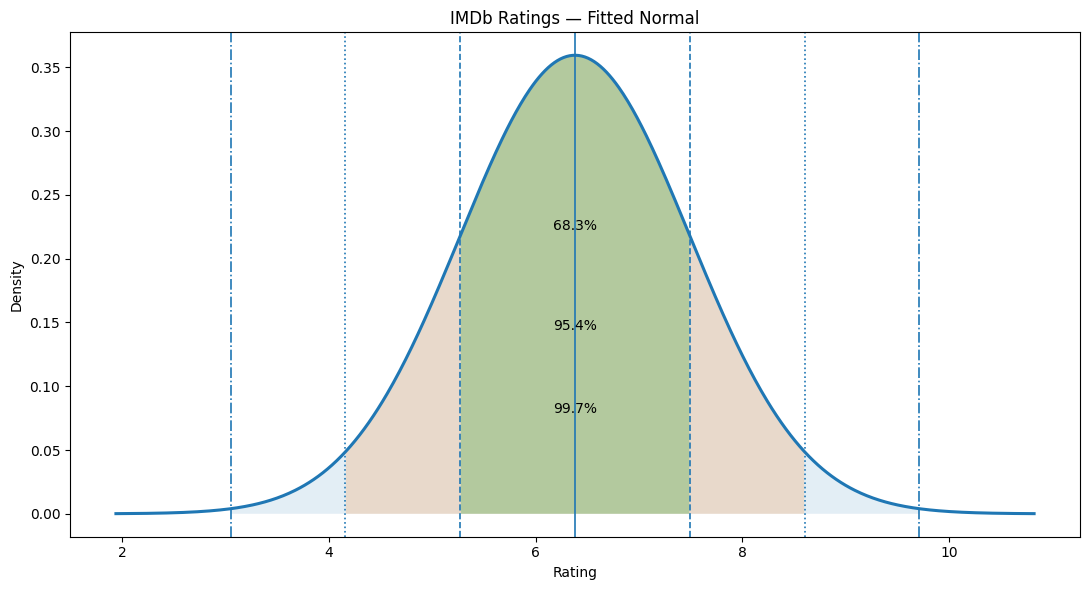

In [136]:
import numpy as np
from math import erf, sqrt

s = pd.to_numeric(df['rating'], errors = 'coerce').dropna()
s = s[(s >= 0) & (s <= 10)]
mu, sigma = s.mean(), s.std(ddof = 1)

xs = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 600)
pdf = (1 / (sigma*np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs-mu) / sigma) **2)


def cdf(x): return 0.5*(1 + erf((x-mu)/(sigma*sqrt(2))))

plt.figure(figsize = (11,6))


for k, alpha in zip([3,2,1], [0.12, 0.18, 0.28]): 
    lo, hi = mu - k * sigma, mu + k * sigma
    plt.fill_between(xs, 0, pdf, where = (xs >= lo) & (xs <= hi), alpha = alpha)

plt.plot(xs, pdf, linewidth = 2.2)
for x, style in [(mu,'-'), (mu-sigma,'--'), (mu+sigma,'--'),
                 (mu-2*sigma,':'), (mu+2*sigma,':'),
                 (mu-3*sigma,'-.') , (mu+3*sigma,'-.')]:
    plt.axvline(x, linestyle = style, linewidth = 1.2)

ymax = pdf.max()
p1 = cdf(mu + sigma) - cdf(mu - sigma)
p2 = cdf(mu + 2 * sigma) - cdf(mu - 2 * sigma)
p3 = cdf(mu + 3 * sigma) - cdf(mu - 3 * sigma)
plt.text(mu, ymax * 0.62, f"{p1 * 100:.1f}%", ha = 'center')
plt.text(mu, ymax * 0.40, f"{p2 *100:.1f}%", ha = 'center')
plt.text(mu, ymax * 0.22, f"{p3 *100:.1f}%", ha = 'center')

plt.title("IMDb Ratings — Fitted Normal")
plt.xlabel("Rating"); plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../visuals/ratings_normal_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Query 4: Top 20 Actors by Film Count 

In [101]:
sql = '''

SELECT actor_name, COUNT(*) AS film_count
FROM roles
GROULP BY actor_name
ORDER BY film_count DESC
LIMIT 20;
'''

In [107]:
actor_cols = [c for c in df.columns if ("actor" in c.lower()) and c.lower().endswith("_name")]
id_cols    = [c for c in ["tconst", "title_id", "id", "movie_id"] if c in df.columns]

actors_long = df[id_cols + actor_cols].melt(
    id_vars=id_cols, value_vars=actor_cols,
    var_name="slot", value_name="actor"
)

actors_long["actor"] = (
    actors_long["actor"].astype(str).str.strip()
    .replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "NONE": np.nan, "None": np.nan, "N/A": np.nan})
)

actors_long = actors_long.dropna(subset=["actor"])

if id_cols:
    actors_long = actors_long.drop_duplicates(id_cols + ["actor"])


actors_long["actor_norm"] = (
    actors_long["actor"].str.replace(r"\s+", " ", regex=True).str.title()
)

top_actors = (
    actors_long["actor_norm"]
    .value_counts()
    .head(20)
    .rename_axis("actor")
    .reset_index(name="film_count")
)

display(top_actors)


,actor,film_count
0,Robert De Niro,53
1,Morgan Freeman,43
2,Bruce Willis,38
3,Matt Damon,37
4,Steve Buscemi,36
5,Johnny Depp,36
6,Brad Pitt,33
7,Nicolas Cage,33
8,Will Ferrell,32
9,Liam Neeson,32


## Chart 4: Top 20 Actors by Film

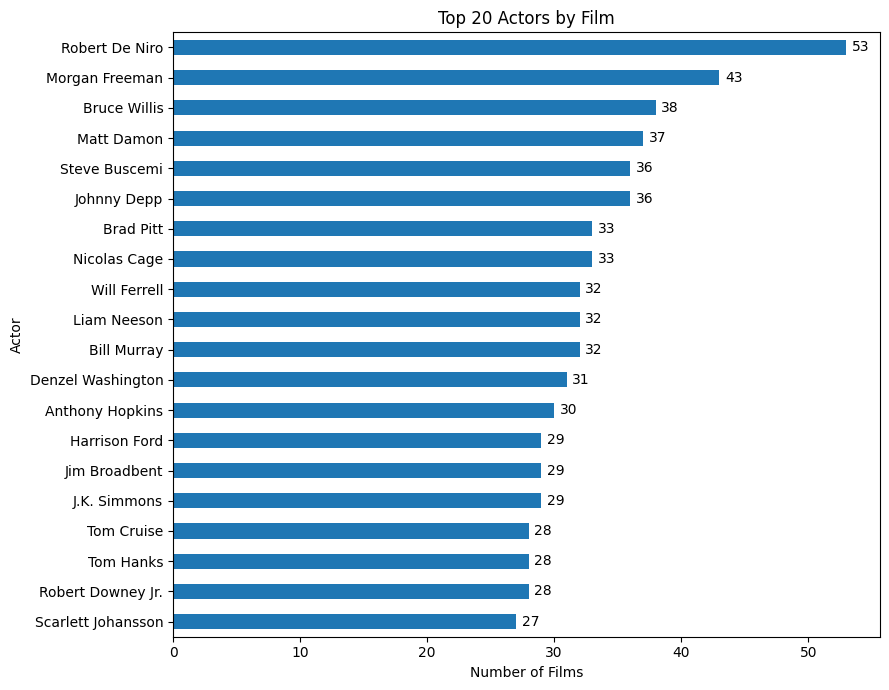

Saved to: figures/top_actors_by_count.png


In [155]:
from pathlib import Path



plot_df = top_actors.copy()
plot_df = plot_df[
    plot_df["actor"].notna() &
    ~plot_df["actor"].astype(str).str.strip().str.lower().isin(["nan", "none", "n/a", ""])
]

fig_dir = Path("figures")
fig_dir.mkdir(parents = True, exist_ok = True)
out_file = fig_dir / "top_actors_by_count.png"

ax = plot_df.sort_values("film_count").plot(kind = "barh", x = "actor", y = "film_count", figsize = (9, 7))
ax.set_title("Top 20 Actors by Film")
ax.set_xlabel("Number of Films")
ax.set_ylabel("Actor")
if ax.legend_: 
    ax.legend_.remove()
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}",
                (p.get_width(), p.get_y() + p.get_height()/2),
                va = "center", ha = "left", xytext = (4, 0), textcoords = "offset points")
plt.tight_layout()
plt.savefig(out_file, dpi = 300, bbox_inches = "tight")
plt.show()
print("Saved to:", out_file)


## Query 5: Average IMDb Ratings by Year
After detecting the year and rating columns, the data is cleaned and average IMDb ratings per year are calculated. This provides a long-term view of rating trends across decades of film history. 

In [81]:
tmp = df[[year_col, rating_col]].copy()

tmp[year_col] = pd.to_numeric(tmp[year_col], errors = "coerce")
tmp[rating_col] = pd.to_numeric(tmp[rating_col], errors = "coerce")

ratings_by_year = (
    tmp.dropna(subset = [year_col, rating_col])
        .groupby(year_col, as_index = False)[rating_col].mean()
        .rename(columns = {year_col: "year", rating_col: "avg_rating"})
        .sort_values("year")
)
ratings_by_year.head()

,year,avg_rating
0,1916.0,8.00
1,1920.0,4.80
2,1925.0,8.30
3,1927.0,8.30
4,1929.0,7.15


## Chart 5: Ratings by Year
The chart below calculates the average IMDb ratings by year without titles. It highlights how audience ratings fluctuated over time, helping to identify broader trends (e.g., whether more recent films tend to score highter or lower compared to earlier years). 

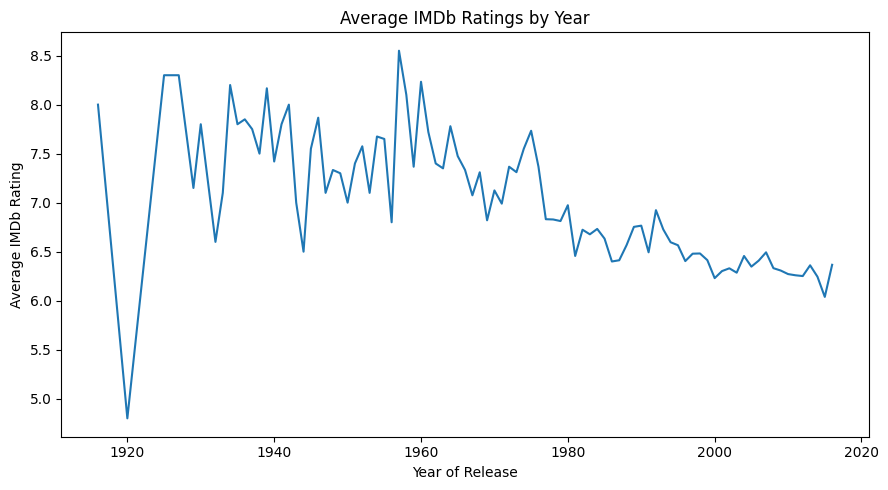

In [82]:
fig_dir = Path("figures"); fig_dir.mkdir(exist_ok = True, parents = True)
out_file = fig_dir / "avg_rating_by_year.png"

plt.figure(figsize = (9, 5))
plt.plot(ratings_by_year["year"], ratings_by_year["avg_rating"])
plt.xlabel("Year of Release")
plt.ylabel("Average IMDb Rating")
plt.title("Average IMDb Ratings by Year")
plt.tight_layout()
plt.savefig(out_file, dpi = 200, bbox_inches = "tight")
plt.show()


## Query 6: Budget vs Revenue by Year (Average)

In [ ]:
db_path = Path("../data_raw/imdb_movies.db")
conn = sqlite3.connect(db_path)


sql = '''  

SELECT
  CAST(year AS INTEGER)      AS year,
  AVG(CAST(budget_usd AS REAL)) AS avg_budget_usd,
  AVG(CAST(gross_usd  AS REAL)) AS avg_revenue_usd
FROM titles
WHERE year BETWEEN 1970 AND 2020
  AND budget_usd IS NOT NULL AND budget_usd <> ''
  AND gross_usd  IS NOT NULL AND gross_usd  <> ''
GROUP BY year
ORDER BY year;
'''

directors_sql = pd.read_sql(sql, conn)
conn.close()

directors_sql.head()

## Chart 6: Budget vs. Revenue
The scatterplot above shows the relationship between production budget and worldwide gross revenue. As expeccted, larger budgets often correlate with highter revenue, but there are also many lower budgeted films that achieved strong box office returns. It's a useful lens for understanding financial risk and reward in filmmaking. 

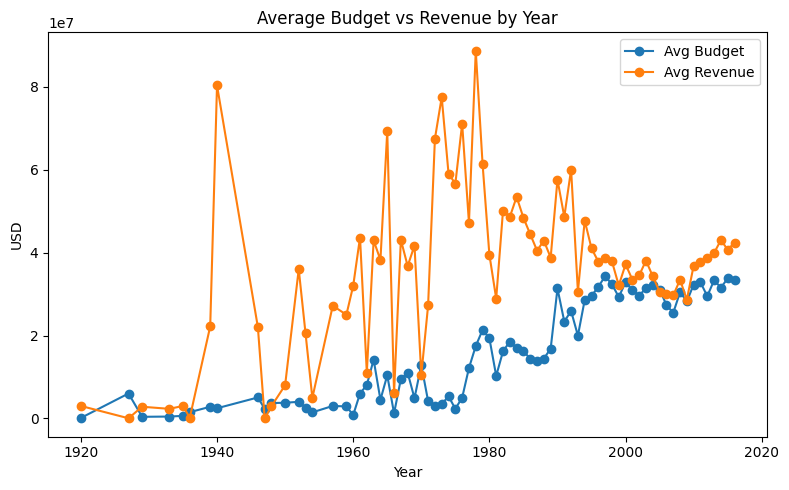

In [157]:
ratings_by_year = (
    base_clip.groupby(year_col, as_index=False)[[budget_col, revenue_col]]
             .mean()
             .sort_values(year_col)
)

from pathlib import Path
import matplotlib.pyplot as plt

fig_dir = Path("figures"); fig_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(trend[year_col], trend[budget_col], label = "Avg Budget", marker = "o")
plt.plot(trend[year_col], trend[revenue_col], label = "Avg Revenue", marker = "o")
plt.xlabel("Year")
plt.ylabel("USD")
plt.title("Average Budget vs Revenue by Year")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "avg_budget_revenue_by_year.png", dpi = 200, bbox_inches = "tight")
plt.show()


## Query 7: Top Direcctors by IMDb Rating

In [158]:
import sqlite3

db_path = Path("../data_raw/imdb_movies.db")
conn = sqlite3.connect(db_path)

sql = """
SELECT director_name AS director,
    COUNT(*) AS films, 
    AVG(imdb_score) AS avg_rating
FROM movie_metadata
WHERE imdb_score IS NOT NULL AND director_name IS NOT NULL
GROUP BY director_name
HAVING COUNT(*) >= 5
ORDER BY avg_rating DESC
LIMIT 20;
"""
with sqlite3.connect(db_path) as conn:
    yearly_avgs = pd.read_sql_query(sql, conn)

yearly_avgs.head(10)

,director,films,avg_rating
0,Christopher Nolan,8,8.425000
1,Quentin Tarantino,8,8.200000
2,Frank Capra,5,8.060000
3,Stanley Kubrick,7,8.000000
4,James Cameron,7,7.914286
5,Alejandro G. Iñárritu,6,7.783333
6,Fred Zinnemann,5,7.760000
7,David Fincher,10,7.750000
8,Peter Jackson,12,7.675000
9,Martin Scorsese,20,7.660000


## Chart 7: Top Direcctors by IMDb Rating
The chart below displays the average IMDb rating by director with a minimum of 5 films, ranked top to bottom. 

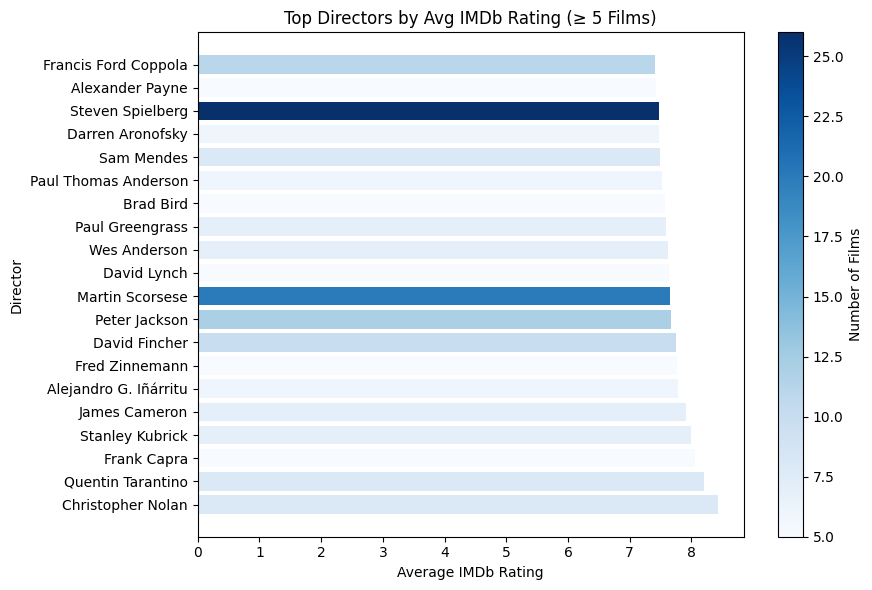

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(9,6))

norm = mcolors.Normalize(vmin=directors_sql["films"].min(), vmax = directors_sql["films"].max())
cmap = cm.Blues

bars = ax.barh(
    directors_sql["director"],
    directors_sql["avg_rating"],
    color = cmap(norm(directors_sql["films"]))
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Number of Films")

ax.set_xlabel("Average IMDb Rating")
ax.set_ylabel("Director")
ax.set_title("Top Directors by Avg IMDb Rating (≥ 5 Films)")

plt.tight_layout()
plt.savefig(fig_dir / "top_directors_avg_rating_colored_by_films.png", dpi = 200, bbox_inches = "tight")
plt.show()



## Chart 6: Correlation Analysis Below: Budget, Revenue, and Rating
To explore the potential relationships between key variables, I computed a correlation matrix. This shows how strongly **budget**, **revenue**, and **IMDb ratings** move together. In this dataset, budget and revenue show only a weak positive correlation, while ratings have very little correlation with either. 

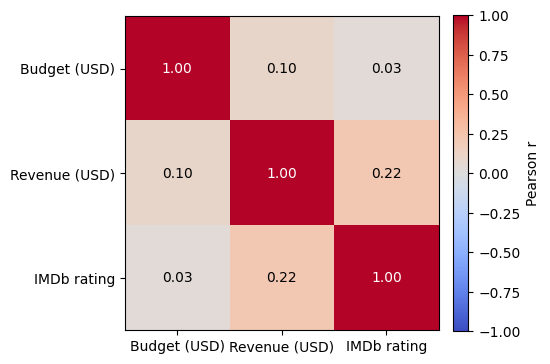

In [160]:
fig, ax = plt.subplots(figsize = (5.6, 5.6))
im = ax.imshow(C, vmin = -1, vmax = 1, cmap = "coolwarm")
fig.colorbar(im, fraction = 0.046, pad = 0.04).set_label("Pearson r")
ax.set_xticks(range(n)); ax.set_xticklabels(labels, rotation=0)
ax.set_yticks(range(n)); ax.set_yticklabels(labels)
ax.set_aspect("equal")

for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{C[i,j]:.2f}",
                ha = "center", va = "center",
                color=("white" if abs(C[i,j]) > 0.5 else "black"))

plt.tight_layout()
plt.savefig("../visuals/corr_heatmap_full.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Data Step: Exporting Aggregates - Shown Below
To support further analysis and dashboarding (e.g., Tableau or PowerBI), I saved the key aggregates as CSV files in the `data_processed/` folder: (`agg_ratings_by_year.csv`), (`agg_ratings_by_decade.csv`), and (`agg_top_actors.csv`). 

This ensures the processed data is reusable outside the notebook. 


In [83]:
# decade aggregate
base_clip["decade"] = (base_clip[year_col] // 10) * 10
ratings_by_decade = (
    base_clip.groupby("decade", as_index=False)[[budget_col, revenue_col]]
             .mean()
             .sort_values("decade")
)


In [79]:
from pathlib import Path
out_dir = Path("../data_processed")
out_dir.mkdir(parents = True, exist_ok = True)

ratings_by_year.to_csv(out_dir / "agg_ratings_by_year.csv", index=False)
ratings_by_decade.to_csv(out_dir / "agg_ratings_by_decade.csv", index=False)
top_actors.to_csv(out_dir / "agg_top_actors.csv", index=False)
